In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sn
from fbprophet import Prophet

In [2]:
data = pd.read_csv('aqi_fillna_pchip.csv',names=['ds','y'], index_col='ds', parse_dates=['ds']) 
data = data.iloc[1:]
data.head()

,y
ds,
2017-11-01 08:00:00,423.0
2017-11-01 09:00:00,420.0
2017-11-01 10:00:00,416.0
2017-11-01 11:00:00,414.0
2017-11-01 12:00:00,414.0


In [3]:
data.isnull().sum(axis=0)

y    0
dtype: int64

In [4]:
data.isna().sum(axis=0)

y    0
dtype: int64

In [5]:
data['y']= pd.to_numeric(data['y'], downcast="float")

In [6]:
daily_data = data.resample('D').apply(np.mean)
daily_data.head()

,y
ds,
2017-11-01,394.125732
2017-11-02,271.289124
2017-11-03,373.875000
2017-11-04,396.333344
2017-11-05,429.875000


In [7]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def plotly_data(data, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=data.index, mode='lines')
    data = [go.Scatter(y=data['y'], name='y', **common_kw) ]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)
plotly_data(data)

In [8]:
# just checking it for dialy_data too, no particular reason to check it
plotly_data(daily_data)

In [9]:
data_fb = data.reset_index()
daily_data_fb = daily_data.reset_index()
daily_data_fb.tail()

,ds,y
1121,2020-11-26,352.750000
1122,2020-11-27,152.333328
1123,2020-11-28,233.833328
1124,2020-11-29,284.125000
1125,2020-11-30,362.333344


In [10]:
data_fb.tail()

,ds,y
27011,2020-11-30 19:00:00,366.0
27012,2020-11-30 20:00:00,368.0
27013,2020-11-30 21:00:00,369.0
27014,2020-11-30 22:00:00,371.0
27015,2020-11-30 23:00:00,372.0


In [11]:
prediction_size = 30
train_data = daily_data_fb[:-prediction_size]
train_data.tail()

,ds,y
1091,2020-10-27,355.041656
1092,2020-10-28,325.500000
1093,2020-10-29,415.958344
1094,2020-10-30,428.583344
1095,2020-10-31,431.000000


In [12]:
from fbprophet import Prophet
import fbprophet
import pandas
print(fbprophet.__version__)
print(pandas.__version__)

0.7.1
1.2.0


In [13]:
m = Prophet(daily_seasonality=True)
m.fit(train_data)

In [14]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1123,2020-11-28
1124,2020-11-29
1125,2020-11-30


In [15]:
forecast = m.predict(future)
New_forecast = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].copy()
#New_forecast = New_forecast.set
New_forecast = New_forecast.join(daily_data_fb.set_index('ds'))
New_forecast.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-11-01,453.713005,381.636586,526.283621,394.125732
2017-11-02,452.118164,373.486723,521.212858,271.289124
2017-11-03,448.577804,379.376304,519.870247,373.875000
2017-11-04,441.779417,362.230855,517.509374,396.333344
2017-11-05,439.930648,359.346502,514.638399,429.875000


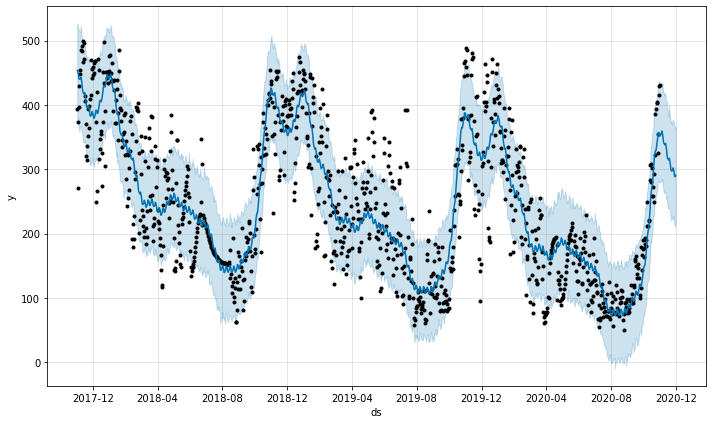

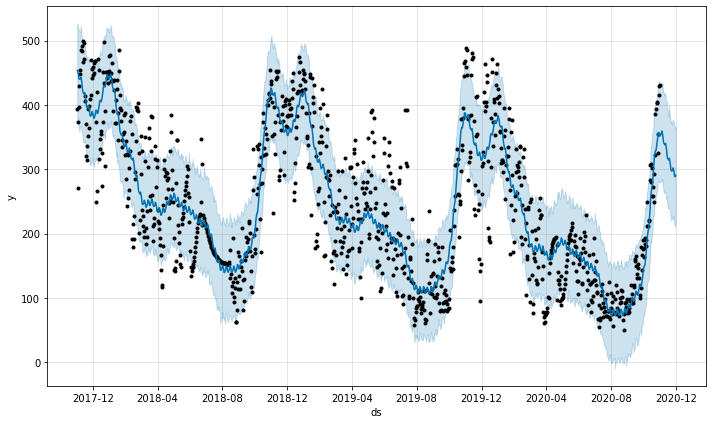

In [16]:
m.plot(forecast)

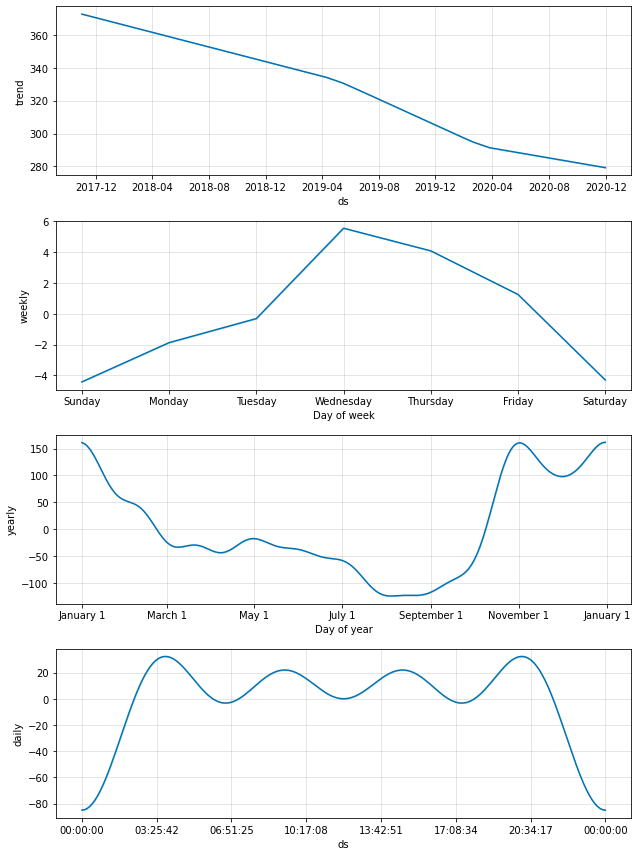

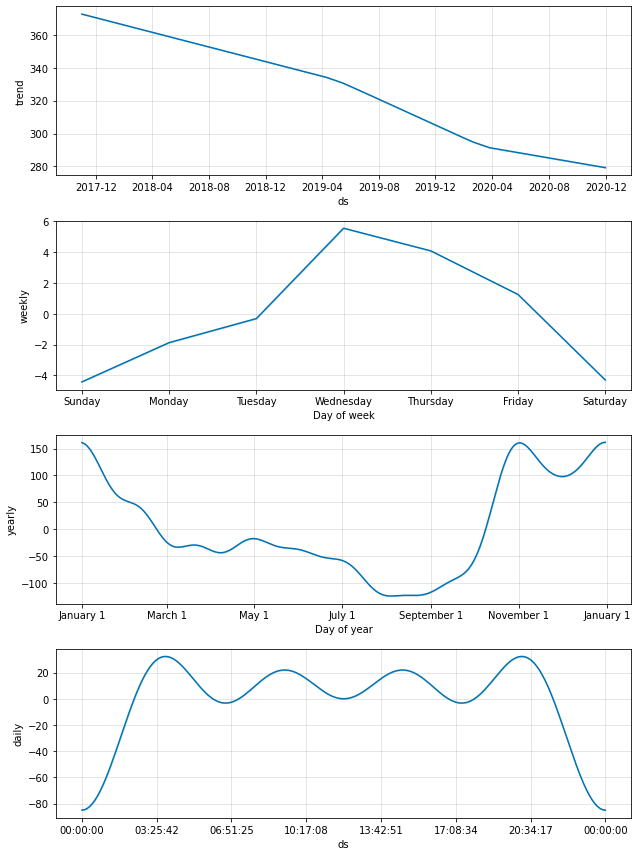

In [17]:
m.plot_components(forecast)

In [18]:
# just same plots by with using plotly lib
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [19]:
plot_components_plotly(m, forecast)


### Evaluation

In [20]:
def calculate_forecast_errors(df, prediction_size):
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [21]:
for err_name, err_value in calculate_forecast_errors(New_forecast, prediction_size).items():
    print(err_name, err_value)

MAPE 21.02475855633174
MAE 69.13967814758547


### Visualization

In [22]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(New_forecast, prediction_size, 100, 'forecast for timeseries')

In [24]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(m, open(filename, 'wb'))

In [46]:
import datetime
loaded_model = pickle.load(open(filename, 'rb'))
date_ = [datetime.datetime.now()] 
date = date_[0].strftime("%Y-%m-%d")
date_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
list_ = [date_obj]
final = np.array(list_)


In [47]:
cols = ['ds']
final = np.array(list_)
data_unseen = pd.DataFrame([final], columns = cols)
prediction = loaded_model.predict(data_unseen)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-02,276.174785,169.723467,315.942564,275.493673,276.79094,-33.555816,-33.555816,-33.555816,-84.965653,...,-0.309421,-0.309421,-0.309421,51.719258,51.719258,51.719258,0.0,0.0,0.0,242.618969


In [44]:
prediction = prediction['yhat']
prediction

KeyError: 'yhat'

In [45]:
prediction

0    242.618969
Name: yhat, dtype: float64